# Convolutional Neural Network on Cifar-10 Dataset

Hello everyone and Prof Di Bo Ya. My name is Denzel Elden Wijaya, and in this notebook, I will demonstrate how to implement Convolutional Neural Network on Cifar-10 Datasets, while the previous one is utilizing the FFNN, or the fully connected Neural Network one, here we will be focusing more into the Convolutional Layers, and the effects of the all the hyperparameters on the performance of the CNN itself. I will extract the raw data and create a custom dataset class that inherits from `torch.utils.data.Dataset`. This custom dataset will then be passed to `torch.utils.data.DataLoader` to enable efficient data loading during training.

The process will include these steps:
1. Load and Prepare the Dataset
2. Build the initial CNN Model
3. Tune the Model
4. Conclusion

## 1. Load and Prepare the Dataset

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CifarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for file_name in os.listdir(class_path):
                    if file_name.endswith((".png", ".jpg", ".jpeg")):
                        self.image_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = CifarDataset(root_dir="/kaggle/input/cifar10/cifar10_train", transform=transform)
test_dataset = CifarDataset(root_dir="/kaggle/input/cifar10/cifar10_test", transform=transform)

cifar_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Total Training Data: {len(train_dataset)}")
print(f"Total Testing Data: {len(test_dataset)}")

Total Training Data: 50000
Total Testing Data: 10000


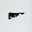

Label: airplane


In [4]:
# let's check the first image and its label

from IPython.display import display

image, label = train_dataset[1]
image = transforms.ToPILImage()(image)
display(image)

class_names = list(train_dataset.class_to_idx.keys())
label_name = class_names[label]

print(f"Label: {label_name}")

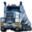

Label: truck


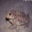

Label: frog


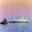

Label: ship


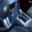

Label: automobile


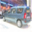

Label: automobile


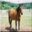

Label: horse


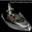

Label: ship


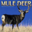

Label: deer


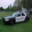

Label: automobile


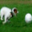

Label: dog


In [5]:
data_iter = iter(cifar_train_loader)
images, labels = next(data_iter)
for i in range(10):
    image = transforms.ToPILImage()(images[i])
    display(image)
    print(f"Label: {class_names[labels[i]]}")

In [6]:
# Check the shape of the images and labels

print(f"Shape of images: {images.shape}")
print(f"Label batch: {labels}")

Shape of images: torch.Size([64, 3, 32, 32])
Label batch: tensor([9, 6, 8, 1, 1, 7, 8, 4, 1, 5, 1, 3, 4, 5, 7, 4, 6, 7, 1, 7, 6, 9, 7, 5,
        9, 3, 8, 6, 5, 0, 4, 3, 6, 6, 1, 5, 9, 9, 7, 4, 7, 6, 4, 4, 1, 5, 8, 2,
        8, 7, 1, 4, 8, 2, 5, 7, 8, 6, 5, 7, 0, 7, 6, 4])


This part does not have any significant difference from the one that we have built on the previous homework, and we have successfully loaded the CIFAR dataset and implemented a custom dataset class. After ensuring that the dataset is properly processed, we've verified that the images and labels are correctly associated and displayed. The dataset is now ready for training.

## 2. Build the Initial CNN Model

With the dataset that we have prepared, we will proceed on building the Neural Network with at least one Convolutional Layer inside. In this phase, we will build the basic one without applying advanced refinements and adjustments. This initial model will be the baseline for the training later. 

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvOnlyCNN(nn.Module):
    def __init__(self):
        super(ConvOnlyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)          
        x = torch.relu(self.fc1(x))     
        return self.fc2(x)            

In [10]:
import torch
import torch.nn.functional as F

def train(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100. * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Acc: {acc:.2f}%")

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

device = torch.device('cuda')
model = ConvOnlyCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, cifar_train_loader, criterion, optimizer, device, epochs=10)
evaluate(model, cifar_test_loader, device)

Epoch [1/10] - Loss: 1.5062 - Acc: 47.00%
Epoch [2/10] - Loss: 1.1902 - Acc: 58.30%
Epoch [3/10] - Loss: 1.0679 - Acc: 62.54%
Epoch [4/10] - Loss: 0.9720 - Acc: 66.05%
Epoch [5/10] - Loss: 0.8929 - Acc: 68.63%
Epoch [6/10] - Loss: 0.8309 - Acc: 70.85%
Epoch [7/10] - Loss: 0.7591 - Acc: 73.43%
Epoch [8/10] - Loss: 0.6885 - Acc: 75.83%
Epoch [9/10] - Loss: 0.6359 - Acc: 77.84%
Epoch [10/10] - Loss: 0.5676 - Acc: 80.40%
Test Accuracy: 59.50%


59.5

From the results, we can see that even without any hyperparameter tuning, dropout layers, or deep architectures, our CNN with a single convolutional layer already achieves around 59% accuracy on the testing set. For comparison: In the previous assignment using a Fully-Connected Neural Network (FFNN), even with various refinements and tuning techniques, the best accuracy we achieved was only around 56–58%.

So, why does CNN perform just as well — or even better — with fewer modifications?
The key lies in how CNN and FFNN process image data:

**CNN (Convolutional Neural Network):**
- Learns and captures spectral features like edges, textures, and shapes.
- Preserves spatial structure of the image.
- Uses local receptive fields and weight sharing for efficient pattern recognition.

**FFNN (Fully Connected Neural Network):**
- Treats the image as a flat vector (e.g., 32×32×3 → 3072D vector).
- Loses spatial relationships between pixels.

## 3. Tune the Model

To further improve model performance and explore the power of CNNs, here are some next steps we can try:
- Add more convolutional layers to capture more complex spatial features.
- Increase the number of neurons in fully connected layers to improve capacity.
- Introduce Dropout layers to reduce overfitting and improve generalization.
- Apply Batch Normalization to stabilize and accelerate training.
- Train for more epochs to allow the model more time to converge.
- Experiment with different learning rates to find the most optimal update speed.
- Try different activation functions like LeakyReLU or ELU.
- Use MaxPooling to gradually reduce spatial dimensions.

All of these enhancements aim to improve the model's ability to learn general features and perform better on unseen data — without overfitting.

### First Step

First of all, let's focus on the CNN Core Implementation:

1. Add a second convolutional layer
→ To ensure the model extract as much spatial fature as it could

2. Add MaxPooling after each conv block
→ To let the model study about the hierachy (edge -> texture -> shape)

3. Add BatchNorm after conv layers
→ To stabilize the training and make the model fast to converge

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RefinedCNN(nn.Module):
    def __init__(self):
        super(RefinedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)                                 

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device('cuda')
model = RefinedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, cifar_train_loader, criterion, optimizer, device, epochs=10)
evaluate(model, cifar_test_loader, device)

Epoch [1/10] - Loss: 1.3565 - Acc: 52.23%
Epoch [2/10] - Loss: 0.9864 - Acc: 65.22%
Epoch [3/10] - Loss: 0.8712 - Acc: 69.64%
Epoch [4/10] - Loss: 0.7898 - Acc: 72.48%
Epoch [5/10] - Loss: 0.7288 - Acc: 74.50%
Epoch [6/10] - Loss: 0.6792 - Acc: 76.47%
Epoch [7/10] - Loss: 0.6289 - Acc: 78.16%
Epoch [8/10] - Loss: 0.5907 - Acc: 79.39%
Epoch [9/10] - Loss: 0.5528 - Acc: 80.53%
Epoch [10/10] - Loss: 0.5183 - Acc: 82.05%
Test Accuracy: 70.63%


70.63

In [11]:
class RefinedCNN2(nn.Module):
    def __init__(self):
        super(RefinedCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x)))) 
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))   
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))   
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        
device = torch.device('cuda')
model = RefinedCNN2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, cifar_train_loader, criterion, optimizer, device, epochs=10)
evaluate(model, cifar_test_loader, device)

Epoch [1/10] - Loss: 1.2543 - Acc: 55.51%
Epoch [2/10] - Loss: 0.8715 - Acc: 69.53%
Epoch [3/10] - Loss: 0.7410 - Acc: 74.21%
Epoch [4/10] - Loss: 0.6500 - Acc: 77.33%
Epoch [5/10] - Loss: 0.5794 - Acc: 79.81%
Epoch [6/10] - Loss: 0.5085 - Acc: 82.33%
Epoch [7/10] - Loss: 0.4528 - Acc: 84.24%
Epoch [8/10] - Loss: 0.3959 - Acc: 86.22%
Epoch [9/10] - Loss: 0.3446 - Acc: 87.99%
Epoch [10/10] - Loss: 0.3026 - Acc: 89.34%
Test Accuracy: 73.48%


73.48

By enhancing the initial CNN model with a second convolutional layer, batch normalization, and max pooling, we observed a significant improvement in test accuracy, reaching approximately 73% — a noticeable increase from the earlier baseline of 58%.These enhancements contributed to better feature extraction, training stability, and generalization. In particular:

1. Additional convolutional layers enabled the model to capture more abstract spatial features. Even when we increase it to 3 layers, the accuracy increases by ~3%.
2. Batch Normalization improved training convergence by reducing internal covariate shift.
3. Max Pooling helped downsample feature maps, reducing overfitting and computational cost.

This result confirms the effectiveness of building a deeper architecture with normalization and pooling in achieving better performance on image classification tasks.

### Second Step

After observing a significant gap between the training and testing accuracy, it is clear that the model is experiencing overfitting. To address this issue and evaluate its impact on generalization, we propose the following next steps:

1. Add Dropout Layers (e.g., 0.3–0.5 before the fully connected layers)
→ This helps reduce overfitting by preventing the model from relying too heavily on specific neurons during training.

2. Adjust the Number of Training Epochs
→ If the training loss is still decreasing steadily at the end of the current training cycle, increasing the number of epochs may allow the model to further improve without prematurely stopping learning.

In [17]:
class RefinedCNN3(nn.Module):
    def __init__(self):
        super(RefinedCNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device('cuda')
model = RefinedCNN3().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Epochs: 10
print("Training from scratch for 10 epochs...")
model_10 = RefinedCNN3().to(device)
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=0.001)
train(model_10, cifar_train_loader, criterion, optimizer_10, device, epochs=10)
evaluate(model_10, cifar_test_loader, device)

# Epochs: 15
print("\nTraining from scratch for 15 epochs...")
model_15 = RefinedCNN3().to(device)
optimizer_15 = torch.optim.Adam(model_15.parameters(), lr=0.001)
train(model_15, cifar_train_loader, criterion, optimizer_15, device, epochs=15)
evaluate(model_15, cifar_test_loader, device)

# Epochs: 20
print("\nTraining from scratch for 20 epochs...")
model_20 = RefinedCNN3().to(device)
optimizer_20 = torch.optim.Adam(model_20.parameters(), lr=0.001)
train(model_20, cifar_train_loader, criterion, optimizer_20, device, epochs=20)
evaluate(model_20, cifar_test_loader, device)


Training from scratch for 10 epochs...
Epoch [1/10] - Loss: 1.3539 - Acc: 52.03%
Epoch [2/10] - Loss: 0.9558 - Acc: 66.25%
Epoch [3/10] - Loss: 0.8222 - Acc: 71.16%
Epoch [4/10] - Loss: 0.7335 - Acc: 74.27%
Epoch [5/10] - Loss: 0.6722 - Acc: 76.53%
Epoch [6/10] - Loss: 0.6203 - Acc: 78.10%
Epoch [7/10] - Loss: 0.5707 - Acc: 79.95%
Epoch [8/10] - Loss: 0.5327 - Acc: 81.45%
Epoch [9/10] - Loss: 0.4931 - Acc: 82.68%
Epoch [10/10] - Loss: 0.4599 - Acc: 83.86%
Test Accuracy: 76.66%

Training from scratch for 15 epochs...
Epoch [1/15] - Loss: 1.3295 - Acc: 52.43%
Epoch [2/15] - Loss: 0.9543 - Acc: 66.31%
Epoch [3/15] - Loss: 0.8228 - Acc: 70.97%
Epoch [4/15] - Loss: 0.7401 - Acc: 74.06%
Epoch [5/15] - Loss: 0.6771 - Acc: 76.18%
Epoch [6/15] - Loss: 0.6198 - Acc: 78.15%
Epoch [7/15] - Loss: 0.5747 - Acc: 79.74%
Epoch [8/15] - Loss: 0.5326 - Acc: 81.42%
Epoch [9/15] - Loss: 0.4979 - Acc: 82.31%
Epoch [10/15] - Loss: 0.4607 - Acc: 83.69%
Epoch [11/15] - Loss: 0.4322 - Acc: 84.66%
Epoch [12/15] 

78.94

**Dropout Rate Experiments**

Initially, we tried adding dropout after every convolutional block with increasing rates (e.g., 0.3, 0.35, 0.4). However, this caused a dramatic drop in performance — the test accuracy fell to 55%, as the model lost critical information during feature extraction. We then refined our approach by applying a single dropout layer before the fully connected layer, which yielded much better results:

a. Dropout rate = 0.5: Accuracy dropped to 70%, indicating the regularization was too strong.
b. Dropout rate = 0.25: Achieved the best result of 76%, outperforming the previous baseline of 73%.

This highlights that dropout should be applied carefully and at the right place. Applying too many dropout layers or using a high rate can disrupt learning, especially in convolutional networks where spatial features are sensitive.

**Epoch Tuning Results**

We also trained the same model from scratch using different epoch values:
•	10 epochs: 76.66%
•	15 epochs: Reached 77.01%
•	20 epochs: Reached 78.94%
•	25 epochs: did not reach 80% and start to plateau
These results suggest that extending training beyond 20 epochs does not bring significant improvements once the model has already converged. It’s more efficient to stop training when the loss no longer decreases meaningfully between epochs.

### Third Step

To further improve training stability and optimize performance, we now focus on adjusting hyperparameters and the learning behavior of the model:

1. Experiment with Different Learning Rates (e.g., 0.0005 or 0.005)
→ Finding the right learning rate is crucial — too high may cause divergence, while too low can slow down convergence or get stuck in suboptimal results.

2. Varying number of neurons (64, 128, 256)
→ To find out which one can give a higher and lower accuracy when being examined. Since number or neurons can not be set statically as it will vary based on the dataset.

3. Batch Size Experimentation
→ Smaller batch sizes may generalize better but result in noisier updates, while larger batches offer more stable gradients but might overfit.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, fc_neurons=128, dropout_rate=0.25):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 4 * 4, fc_neurons)
        self.fc2 = nn.Linear(fc_neurons, 10)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [22]:
## Learning Rate Experiments

learning_rates = [0.0005, 0.001, 0.005]
for lr in learning_rates:
    print(f"\nTraining CNNModel with learning rate = {lr}")
    model = CNNModel(fc_neurons=128, dropout_rate=0.25).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train(model, cifar_train_loader, criterion, optimizer, device, epochs=20)
    evaluate(model, cifar_test_loader, device)


Training CNNModel with learning rate = 0.0005
Epoch [1/20] - Loss: 1.3847 - Acc: 50.23%
Epoch [2/20] - Loss: 0.9981 - Acc: 65.00%
Epoch [3/20] - Loss: 0.8645 - Acc: 69.73%
Epoch [4/20] - Loss: 0.7817 - Acc: 72.73%
Epoch [5/20] - Loss: 0.7230 - Acc: 74.75%
Epoch [6/20] - Loss: 0.6671 - Acc: 76.68%
Epoch [7/20] - Loss: 0.6218 - Acc: 78.28%
Epoch [8/20] - Loss: 0.5889 - Acc: 79.36%
Epoch [9/20] - Loss: 0.5529 - Acc: 80.38%
Epoch [10/20] - Loss: 0.5254 - Acc: 81.28%
Epoch [11/20] - Loss: 0.4964 - Acc: 82.36%
Epoch [12/20] - Loss: 0.4673 - Acc: 83.51%
Epoch [13/20] - Loss: 0.4432 - Acc: 84.30%
Epoch [14/20] - Loss: 0.4191 - Acc: 85.17%
Epoch [15/20] - Loss: 0.4012 - Acc: 85.71%
Epoch [16/20] - Loss: 0.3780 - Acc: 86.58%
Epoch [17/20] - Loss: 0.3647 - Acc: 87.08%
Epoch [18/20] - Loss: 0.3389 - Acc: 87.82%
Epoch [19/20] - Loss: 0.3246 - Acc: 88.29%
Epoch [20/20] - Loss: 0.3132 - Acc: 88.80%
Test Accuracy: 78.66%

Training CNNModel with learning rate = 0.001
Epoch [1/20] - Loss: 1.3210 - Acc:

You can see that when the learning rate is too aggressive — as in the case of lr = 0.005 — the model's performance on the test set decreases significantly (accuracy drops to 74%). This happens because a high learning rate causes the model to overshoot optimal weights, leading to unstable training and poor generalization.

On the other hand, a very low learning rate like lr = 0.0005 results in slower convergence, and although it still achieves decent performance (78%), it is not optimal in terms of both training efficiency and final accuracy.

Therefore, a learning rate of 0.001 strikes the best balance between convergence speed and stability, achieving the highest accuracy of 79.19%. This value is thus considered the best choice for our model and dataset.

In [18]:
## Neuron Size Tuning

fc_sizes = [64, 128, 256]
for size in fc_sizes:
    print(f"\nTraining CNNModel with FC neurons = {size}")
    model = CNNModel(fc_neurons=size, dropout_rate=0.25).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train(model, cifar_train_loader, criterion, optimizer, device, epochs=20)
    evaluate(model, cifar_test_loader, device)


Training CNNModel with FC neurons = 64
Epoch [1/20] - Loss: 1.3534 - Acc: 51.45%
Epoch [2/20] - Loss: 0.9533 - Acc: 66.35%
Epoch [3/20] - Loss: 0.8185 - Acc: 71.33%
Epoch [4/20] - Loss: 0.7428 - Acc: 74.02%
Epoch [5/20] - Loss: 0.6821 - Acc: 76.14%
Epoch [6/20] - Loss: 0.6264 - Acc: 78.22%
Epoch [7/20] - Loss: 0.5845 - Acc: 79.57%
Epoch [8/20] - Loss: 0.5452 - Acc: 80.83%
Epoch [9/20] - Loss: 0.5067 - Acc: 82.27%
Epoch [10/20] - Loss: 0.4737 - Acc: 83.27%
Epoch [11/20] - Loss: 0.4433 - Acc: 84.39%
Epoch [12/20] - Loss: 0.4169 - Acc: 85.30%
Epoch [13/20] - Loss: 0.3913 - Acc: 86.18%
Epoch [14/20] - Loss: 0.3743 - Acc: 86.56%
Epoch [15/20] - Loss: 0.3526 - Acc: 87.51%
Epoch [16/20] - Loss: 0.3270 - Acc: 88.54%
Epoch [17/20] - Loss: 0.3088 - Acc: 88.99%
Epoch [18/20] - Loss: 0.2946 - Acc: 89.58%
Epoch [19/20] - Loss: 0.2793 - Acc: 90.04%
Epoch [20/20] - Loss: 0.2718 - Acc: 90.38%
Test Accuracy: 79.21%

Training CNNModel with FC neurons = 128
Epoch [1/20] - Loss: 1.3721 - Acc: 50.36%
Epoc

In [20]:
## Batch Size Tuning

batch_sizes = [32, 64, 128]
for bs in batch_sizes:
    print(f"\nTraining CNNModel with batch size = {bs}")
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    model = CNNModel(fc_neurons=128, dropout_rate=0.25).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train(model, train_loader, criterion, optimizer, device, epochs=20)
    evaluate(model, test_loader, device)


Training CNNModel with batch size = 32
Epoch [1/20] - Loss: 1.3048 - Acc: 53.36%
Epoch [2/20] - Loss: 0.9367 - Acc: 66.93%
Epoch [3/20] - Loss: 0.8101 - Acc: 71.62%
Epoch [4/20] - Loss: 0.7252 - Acc: 74.70%
Epoch [5/20] - Loss: 0.6626 - Acc: 76.87%
Epoch [6/20] - Loss: 0.6085 - Acc: 78.65%
Epoch [7/20] - Loss: 0.5588 - Acc: 80.49%
Epoch [8/20] - Loss: 0.5173 - Acc: 81.90%
Epoch [9/20] - Loss: 0.4771 - Acc: 83.26%
Epoch [10/20] - Loss: 0.4421 - Acc: 84.61%
Epoch [11/20] - Loss: 0.4101 - Acc: 85.54%
Epoch [12/20] - Loss: 0.3834 - Acc: 86.49%
Epoch [13/20] - Loss: 0.3616 - Acc: 87.22%
Epoch [14/20] - Loss: 0.3399 - Acc: 87.90%
Epoch [15/20] - Loss: 0.3138 - Acc: 88.89%
Epoch [16/20] - Loss: 0.3007 - Acc: 89.26%
Epoch [17/20] - Loss: 0.2835 - Acc: 89.99%
Epoch [18/20] - Loss: 0.2682 - Acc: 90.48%
Epoch [19/20] - Loss: 0.2536 - Acc: 90.97%
Epoch [20/20] - Loss: 0.2451 - Acc: 91.25%
Test Accuracy: 79.27%

Training CNNModel with batch size = 64
Epoch [1/20] - Loss: 1.3519 - Acc: 51.64%
Epoch

Analysis:
- Batch size = 32 resulted in the best test accuracy (79.27%), likely due to noisier updates that help the model generalize better and avoid overfitting.
- Batch size = 64 also performed well and remained stable, offering a good balance between training speed and accuracy.
- Batch size = 128, while computationally faster, led to a slight drop in performance. This is likely because larger batches provide smoother gradients, which can reduce the regularizing effect of gradient noise and make the model prone to overfitting.

Conclusion:
Smaller batch sizes such as 32 tend to offer better generalization at the cost of longer training time per epoch. For this model and dataset, a batch size of 32 is the most effective in terms of test performance, confirming the trade-off between stability and generalization that batch size introduces.

## 4. Conclusion

Throughout this project, we progressively enhanced our CNN model through architectural improvements and training optimizations. Each tuning component served a unique purpose in improving the model’s performance, generalization, and training stability.
1. Convolutional Layers

    Adding more convolutional layers allowed the model to learn hierarchical representations of features — from simple edges to complex textures and shapes. This deeper feature extraction significantly improved test accuracy compared to a shallow model. (59% -> 70%)

2. Batch Normalization & Max Pooling

    Batch normalization helped stabilize and accelerate training by normalizing activations, while max pooling allowed the model to downsample feature maps hierarchically, reducing overfitting and capturing essential patterns. Together, they created a strong backbone for image understanding.

3. Dropout Layers

    Dropout was effective in reducing overfitting, particularly when placed before the fully connected layer. However, excessive dropout or applying it too early (e.g., after every convolution) disrupted feature learning. A moderate dropout rate (e.g., 0.25) applied at the right position proved to be the most effective.

4. Number of Epochs
    
    Increasing the number of epochs gave the model more time to learn meaningful patterns. However, after a certain point (e.g., beyond 20 epochs), improvements in accuracy plateaued, making further training inefficient. Thus, more epochs do not always mean better performance.

5. Learning Rate

    The learning rate significantly impacted the convergence behavior. A well-balanced rate like 0.001 achieved the best results. Too low (0.0005) led to slow learning, while too high (0.005) caused unstable training or divergence.

6. Number of Neurons

    The number of neurons in the fully connected layer determined the capacity of the final classifier. Interestingly, a size of 64 neurons provided the best generalization, achieving the highest test accuracy. While 128 neurons offered a balanced performance, increasing to 256 neurons led to overfitting, with higher training accuracy but no improvement — and even a slight drop — in test performance. But 32 neurons will give you an underfitting result, hence fo this dataset, 64 neuron is the best number.

8. Batch Size

    Batch size influenced the stability and generalization of the model. A batch size of 32 produced slightly better results due to noisier updates (which help avoid local minima), while larger sizes like 128 were more stable but sometimes overfit slightly


That will be the end of this notebook, hope you gains insight from it. Thank You for giving attention until the end.